<h3>
Not using default RSA libraries because they use random padding and so the cipher text for the same input is different everytime.
</h3>

<h2>RSA Implementation:</h2>

RSA Implementation by: https://www.packetmania.net/en/2022/01/22/Python-Textbook-RSA/

In [1]:
# prime numbers b/w 1 to 1024
prime_numbers = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59,
                 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 
                 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193,
                 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269,
                 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349,
                 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431,
                 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503,
                 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593, 599,
                 601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659, 661, 673,
                 677, 683, 691, 701, 709, 719, 727, 733, 739, 743, 751, 757, 761,
                 769, 773, 787, 797, 809, 811, 821, 823, 827, 829, 839, 853, 857,
                 859, 863, 877, 881, 883, 887, 907, 911, 919, 929, 937, 941, 947,
                 953, 967, 971, 977, 983, 991, 997, 1009, 1013, 1019, 1021]

In [2]:
from random import randrange

def generate_n_bit_odd(n: int):
    '''Generate a random odd number in the range [2**(n-1)+1, 2**n-1]'''
    assert n > 1
    return randrange(2 ** (n - 1) + 1, 2 ** n, 2)


In [3]:
def get_lowlevel_prime(n):
    """Generate a prime candidate not divisible by first primes"""
    while True:
        # Obtain a random odd number
        c = generate_n_bit_odd(n)

        # Test divisibility by pre-generated primes
        for divisor in prime_numbers:
            if c % divisor == 0 and divisor ** 2 <= c:
                break
        else:
            # The for loop did not encounter a break statement,
            # so it passes the low-level primality test.
            return c


In [4]:
def miller_rabin_primality_check(n, k=20):
    '''Miller-Rabin Primality Test with a specified round of test 
    Input:
        n - n > 3, an odd integer to be tested for primality
        k - the number of rounds of testing to perform
    Output:
        True  - passed (n is a strong probable prime)
        False - failed (n is a composite)'''
    
    # For a given odd integer n > 3, write n as (2^s)*d+1,
    # where s and d are positive integers and d is odd.
    assert n > 3
    if n % 2 == 0:
        return False
    
    s, d = 0, n - 1
    while d % 2 == 0:
        d >>= 1
        s += 1

    for _ in range(k):
        a = randrange(2, n - 1)
        x = pow(a, d, n)
        
        if x == 1 or x == n - 1:
            continue
        
        for _ in range(s):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            # The for loop did not encounter a break statement,
            # so it fails the test, it must be a composite
            return False

    # Passed the test, it is a strong probable prime
    return True


In [5]:
def get_random_prime(num_bits):
    while True:
        pp = get_lowlevel_prime(num_bits)
        if miller_rabin_primality_check(pp):
            return pp


In [6]:
def gcd(a, b):
    '''Computes the Great Common Divisor using the Euclid's algorithm'''
    while b:
        a, b = b, a % b
    return a

def lcm(a, b):
    """Computes the Lowest Common Multiple using the GCD method."""
    return a // gcd(a, b) * b


In [7]:
def exgcd(a, b):
    """Extended Euclidean Algorithm that can give back all gcd, s, t 
    such that they can make Bézout's identity: gcd(a,b) = a*s + b*t
    Return: (gcd, s, t) as tuple"""
    old_s, s = 1, 0
    old_t, t = 0, 1
    while b:
        q = a // b
        s, old_s = old_s - q * s, s
        t, old_t = old_t - q * t, t
        a, b = b, a % b
    return a, old_s, old_t

def invmod(e, m):
    """Find out the modular multiplicative inverse x of the input integer
    e with respect to the modulus m. Return the minimum positive x"""
    g, x, y = exgcd(e, m)
    assert g == 1

    # Now we have e*x + m*y = g = 1, so e*x ≡ 1 (mod m).
    # The modular multiplicative inverse of e is x.
    if x < 0:
        x += m
    return x


In [8]:
# RSA_DEFAULT_EXPONENT = 65537
# RSA_DEFAULT_MODULUS_LEN = 2048
RSA_DEFAULT_EXPONENT = 5
RSA_DEFAULT_MODULUS_LEN = 1024

class RSA:
    """Implements the RSA public key encryption/decryption with default
    exponent 65537 and default key size 2048"""

    def __init__(self, key_length=RSA_DEFAULT_MODULUS_LEN,
                 exponent=RSA_DEFAULT_EXPONENT, fast_decrypt=False):
        self.e = exponent
        self.fast = fast_decrypt
        t = 0
        p = q = 2

        while gcd(self.e, t) != 1:
            p = get_random_prime(key_length // 2)
            q = get_random_prime(key_length // 2)
            t = lcm(p - 1, q - 1)

        self.n = p * q
        self.d = invmod(self.e, t)

        if (fast_decrypt):
            self.p, self.q = p, q
            self.d_P = self.d % (p - 1)
            self.d_Q = self.d % (q - 1)
            self.q_Inv = invmod(q, p)
    
    def encrypt(self, binary_data: bytes):
      int_data = int.from_bytes(binary_data, 'big')
      return pow(int_data, self.e, self.n)
	
    def decrypt(self, encrypted_int_data: int):
      int_data = pow(encrypted_int_data, self.d, self.n)
      # return bytes(int_data)
      num_bits = 56
      bin = f'{int_data:0{num_bits}b}'

      # Converting Binary to HEX bytes
      padding = 16
      bin_to_hex = int(bin,2)
      x = f"{bin_to_hex:#0{padding}x}"
      x = x.split('x')[1]

      return bytes.fromhex(x)
    
    def get_key_pair(self):
      print("Public Key: n[",self.n,"], e[",self.e,"]")
      print("Private Key: n[",self.n,"], d[",self.d,"]")


    # def decrypt_fast(self, encrypted_int_data: int):
    # # Use Chinese Remaider Theorem + Fermat's Little Theorem to
    # # do fast RSA description
    #   assert self.fast == True
    #   m1 = pow(encrypted_int_data, self.d_P, self.p)
    #   m2 = pow(encrypted_int_data, self.d_Q, self.q)
    #   t = m1 - m2
    #   if t < 0:
    #       t += self.p
    #   h = (self.q_Inv * t) % self.p
    #   m = (m2 + h * self.q) % self.n
    #   return bytes(m)

<h2>Generating Keys:</h2>

In [9]:
rsa = RSA()

In [10]:
rsa.get_key_pair()

Public Key: n[ 95450569818573704612479882686839933094711651303872790488110665684520448551870830602226368971979988703974332472791955100759287163607078806202201170666024167679961508442031626968017976348355113639627465984554429175732687071144276863948650163151459267690575278199813789630551708160635179611721586724344775935169 ], e[ 5 ]
Private Key: n[ 95450569818573704612479882686839933094711651303872790488110665684520448551870830602226368971979988703974332472791955100759287163607078806202201170666024167679961508442031626968017976348355113639627465984554429175732687071144276863948650163151459267690575278199813789630551708160635179611721586724344775935169 ], d[ 2121123773746082324721775170818665179882481140086062010846903681878232190041574013382808199377333082310540721617599002239095270302379529026715581570356092166578746785211051197180525077611286346568024112035420942779576426249541591669528519298020941984516138772124676359021933337813331314681900073928061699389 ]


In [11]:
message = b'\x00\x00\x00\x00\x0f\xff\xfe'

In [12]:
E = rsa.encrypt(message)
E

1267638511016150027428383686624

In [13]:
rsa.encrypt(message)

1267638511016150027428383686624



> Gives the same cipher text for same plain text.



In [14]:
D = rsa.decrypt(E)
D

b'\x00\x00\x00\x00\x0f\xff\xfe'

<h2>
Probable Message Attack:<br>

Attacker has the following information:
1.   Public Key of B.
2.   Cipher Text.
3.   And knowledge that DES key of 56 bits is being exchanged (keyspace: 2^56).
</h2>


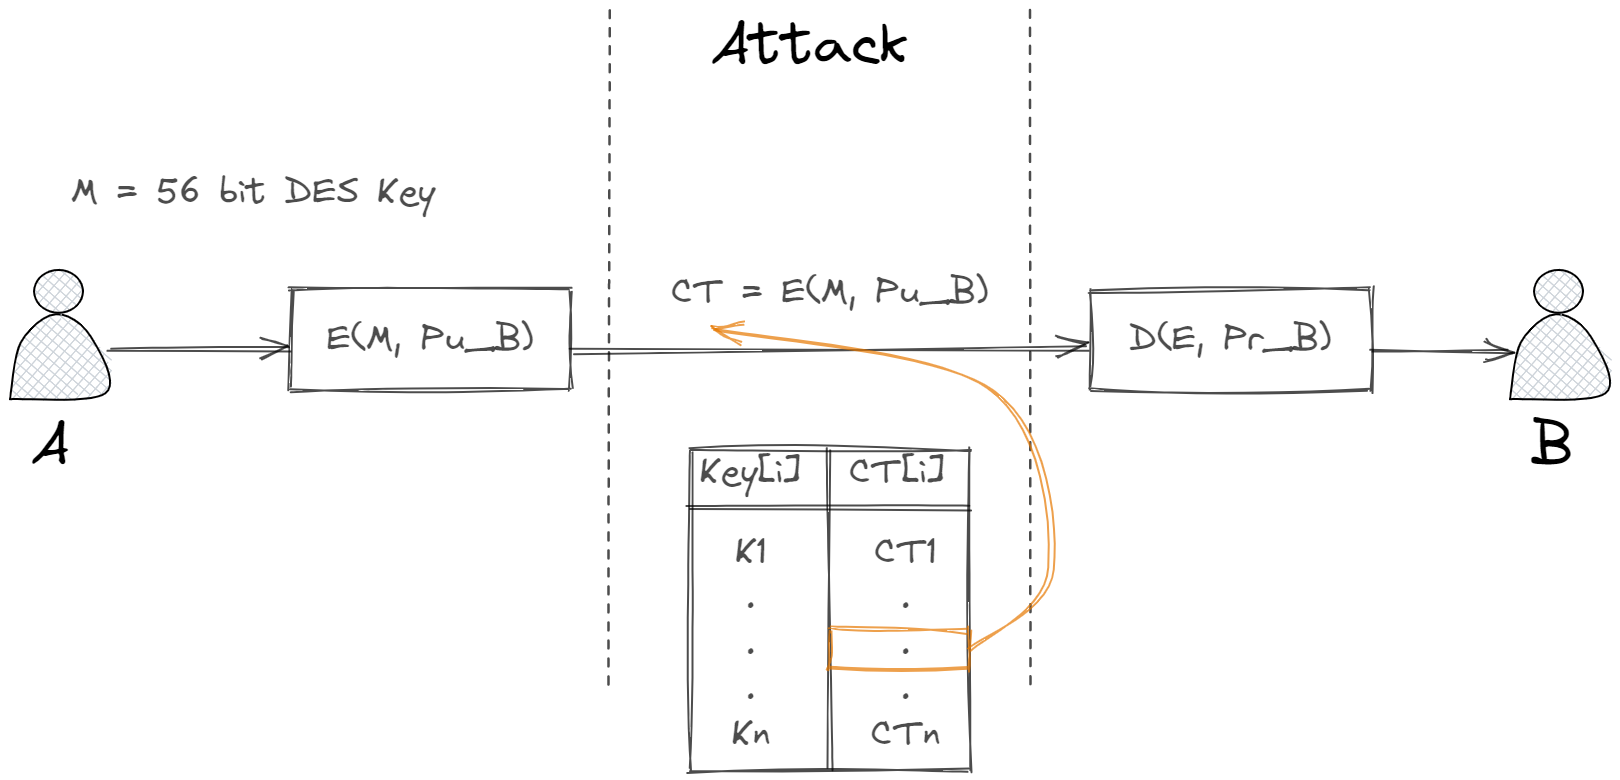

In [15]:
# Attacker has cipher Text
ciphertxt = E
ciphertxt

1267638511016150027428383686624

In [16]:
data_hex = []
data_cipher = []
num_bits = 56
padding = 16

for num in range(0, pow(2,56)):
  
  # Generating Binary numbers of 56 bits  
  bin = f'{num:0{num_bits}b}'

  #Converting Binary to HEX bytes
  bin_to_hex = int(bin,2)
  x = f"{bin_to_hex:#0{padding}x}"
  x = x.split('x')[1]
  x = bytes.fromhex(x)

  data_hex.append(x)

  # Generating Cipher Text from HEX
  cipher = rsa.encrypt(x)
  data_cipher.append(cipher)
  if cipher == ciphertxt:
    ind = num
    break

In [17]:
# Getting the index a the cipher text that matches the 
# message to show the corresponding key (HEX form)
print("Index: ",ind)
print("key: ", data_hex[ind])

Index:  1048574
key:  b'\x00\x00\x00\x00\x0f\xff\xfe'


In [18]:
if (message == data_hex[ind]):
  print("The message is found!")
else:
  print("Unable find the message.")

The message is found!
